In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from pymatgen.analysis import magnetism

In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
Data = pd.read_excel(r'Data.xlsx', index_col=0)

In [4]:
Data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
H3S,2,0.790569,0.759147,0.750616,0.750049,0.750001,1,16,15,4.750000,...,46.500000,194,1.250000,1.000000,0.000000,0.000000,False,0.035456,0.006648,147.0
Ba100Ca99Cu145Hg33O420Pb17,6,0.574387,0.527459,0.516629,0.516020,0.515972,8,82,74,23.561425,...,104.430150,12,1.821867,2.105651,2.395577,0.859951,False,0.803211,0.165437,143.0
Ba1035Ca1035Cu1555Hg375O4104,5,0.572747,0.520734,0.507411,0.506507,0.506420,8,80,72,23.024062,...,104.234706,12,1.808119,2.025666,2.381540,0.647828,False,0.803211,0.167923,135.8
Ba2070Ca2070Cu3110Hg750O8187,5,0.572343,0.520183,0.506782,0.505868,0.505780,8,80,72,23.043553,...,104.237962,12,1.807871,2.023105,2.384630,0.648669,False,0.803211,0.167961,135.4
Ba200Ca200Cu300Hg100O829,5,0.571674,0.521679,0.509699,0.508967,0.508903,8,80,72,23.653775,...,103.279758,12,1.815838,2.035605,2.455494,0.859423,False,0.803211,0.166091,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As9Fe10La10O10P,5,0.488621,0.387712,0.322828,0.298729,0.282116,8,57,49,30.550000,...,74.282500,12,2.000000,1.750000,4.000000,0.000000,True,0.745613,0.122382,0.0
As200Ca81Ce19Fe100,4,0.596458,0.530189,0.504146,0.500683,0.500055,20,58,38,29.805000,...,29.125113,166,2.000000,1.500000,6.547500,0.047500,False,0.293972,0.048801,0.0
As18Fe20O20P2Pr13Sr7,6,0.458598,0.362455,0.305205,0.285416,0.272440,8,59,51,29.212500,...,75.774375,12,2.000000,1.750000,3.750000,0.487500,False,0.787757,0.124658,0.0


In [6]:
train_df, test_df = train_test_split(Data, test_size=0.2, random_state=0)

### Train/validate the model with hyperparameter tuning

In [9]:
etr = ExtraTreesRegressor(random_state = 0)

pipe = Pipeline([
    ('decorrelation', MyDecorrelator(0.9)), 
    ('threshold', VarianceThreshold(threshold = 0)), 
    ('feature_selector', SelectPercentile(f_regression)), 
    ('etr', etr)
], verbose = 1)

In [10]:
param_grid = {
    "etr__n_estimators": [100, 250, 500, 1000],              #Tune the number of estimators
    "etr__max_features": [1, 0.75 ,0.5],                 #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [100, 75, 50]           #Tune the percentage of features to retain in terms of f_regression score
}
search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = 5)

In [14]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.8s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   2.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   4.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   4.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   8.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   8.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   8.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  11.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  11.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  11.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  45.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  45.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  45.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  10.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.9s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   9.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.8s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   8.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  51.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.8s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  39.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  39.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 60.7min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.9s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  22.2s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x00000210BFBFD048>)),
                                       ('etr',
                                        ExtraTreesRegressor(bootstrap=False,
                                                            ccp_alpha=0.0,
                                                            criterion='mse',
                                                            max_d...
                                                            min_weight

In [15]:
search.best_params_

{'etr__max_features': 0.5,
 'etr__n_estimators': 250,
 'feature_selector__percentile': 100}

### Test the model on the testing set

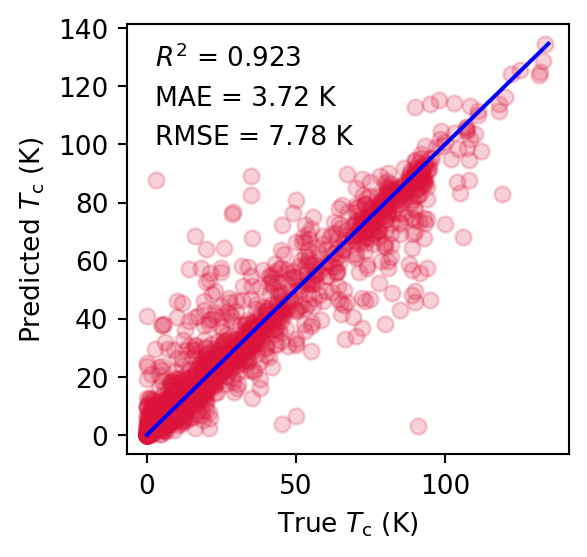

In [17]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values


test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

## Predict LK-99

In [24]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

def get_compostion(c): # Function to get compositions from chemical formula using pymatgen

    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):

    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

C:\Users\giovanni\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [62]:
text_processor.process("Cu1Pb9(PO4)6O")

(['CuO25P6Pb9'], [('Cu1Pb9(PO4)6O', 'CuO25P6Pb9')])

In [70]:
d = pd.DataFrame(['Cu9O250P60Pb91'], columns = ['Components'])

In [71]:
b = featurizing(d)

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

In [72]:
search.predict(b)

array([7.6991966])